In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import contractions


from time import time
import numpy as np
import pandas as pd
import tensorflow as tf

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3

# TF IDF Imports


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

2024-03-12 22:27:24.401434: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 22:27:24.429663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 22:27:24.429697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 22:27:24.430603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 22:27:24.435948: I tensorflow/core/platform/cpu_feature_guar

In [63]:
df = pd.read_csv('./datasets/test_filtered_data.csv')

In [64]:
embedding_dim = 300    # Dimensions used for glove6b100
max_length = 100   # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(df)
test_portion=.2

In [65]:
comments = df['comment_text']
# y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'isToxic']]
y = df['isToxic']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(comments, y, test_size=test_portion)

In [67]:
# y_train_isToxic = y_train['isToxic']
# y_train = y_train.drop(columns=['isToxic'])

# y_test_isToxic = y_test['isToxic']
# y_test = y_test.drop(columns=['isToxic'])

In [68]:
tokenizer = Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    oov_token=oov_tok,
)

In [69]:
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)


In [70]:
sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [71]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [72]:
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [73]:

embeddings_index = {}
f = open('./Glove/glove.840B.300d.txt','r',encoding='utf-8')
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2196016 word vectors.


In [74]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [100]:
from tensorflow.keras.layers import SpatialDropout1D, GRU
input_dimension = vocab_size + 1

model = Sequential()
model.add(Embedding(input_dimension, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [101]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [102]:
from sklearn.utils import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# sample_weights[y_train_isToxic == 1] *= 1.5

In [103]:
history = model.fit(
    padded_sequences, 
    y_train, 
    epochs=10, 
    validation_data=(test_padded_sequences, y_test),
    sample_weight=sample_weights,
    batch_size=128
)
print("Training Complete")

Epoch 1/10
94/94 [==============================] - 27s 275ms/step - loss: 0.7784 - accuracy: 0.4353 - val_loss: 0.5440 - val_accuracy: 0.8856
Epoch 2/10
94/94 [==============================] - 27s 284ms/step - loss: 0.6451 - accuracy: 0.6282 - val_loss: 1.1119 - val_accuracy: 0.7949
Epoch 3/10
94/94 [==============================] - 28s 294ms/step - loss: 0.5415 - accuracy: 0.7412 - val_loss: 0.4474 - val_accuracy: 0.8620
Epoch 4/10
94/94 [==============================] - 28s 301ms/step - loss: 0.5129 - accuracy: 0.8037 - val_loss: 0.4070 - val_accuracy: 0.8623
Epoch 5/10
94/94 [==============================] - 27s 287ms/step - loss: 0.5034 - accuracy: 0.9253 - val_loss: 0.3377 - val_accuracy: 0.9420
Epoch 6/10
94/94 [==============================] - 29s 306ms/step - loss: 0.4736 - accuracy: 0.9298 - val_loss: 0.3126 - val_accuracy: 0.9476
Epoch 7/10
94/94 [==============================] - 27s 286ms/step - loss: 0.4478 - accuracy: 0.9347 - val_loss: 0.2650 - val_accuracy: 0.9450

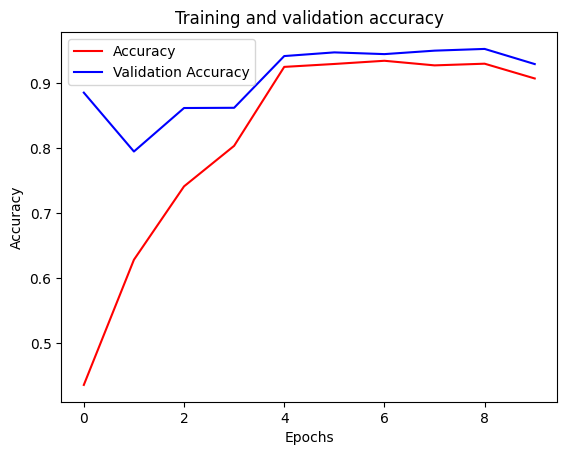

<Figure size 640x480 with 0 Axes>

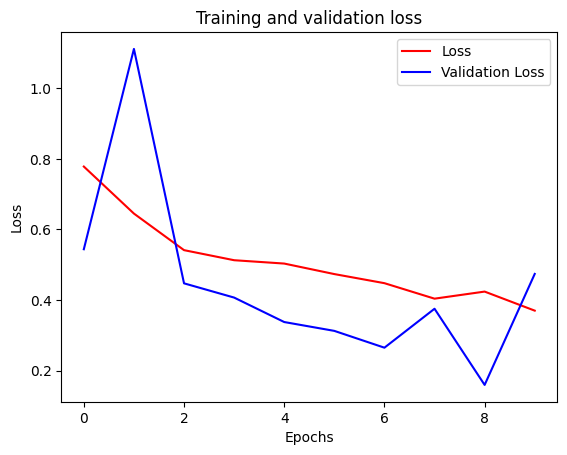

<Figure size 640x480 with 0 Axes>

In [104]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [105]:
def get_indices_above_threshold(pred, threshold=0.5):
    indices = [index for index, value in enumerate(pred) if value > threshold]
    return indices

In [106]:
i = 0

In [192]:
ph = df[df['isToxic'] == 1].iloc[i]

phrase = [ph['comment_text']]
print(phrase)

tokenizer.fit_on_texts(phrase)
sequences_phrase = tokenizer.texts_to_sequences(phrase)
print(sequences_phrase)
padded_sequences_phrase = pad_sequences(sequences_phrase, maxlen=max_length, padding=padding_type, truncating=trunc_type)

pred = model.predict(padded_sequences_phrase)
print(pred)
# print("------")
# if (pred[0][0] > 0.5):
#     print("Toxic")
# if (pred[0][1] > 0.5):
#     print("Severe Toxic")
# if (pred[0][2] > 0.5):
#     print("Obscene")
# if (pred[0][3] > 0.5):
#     print("Threat")
# if (pred[0][4] > 0.5):
#     print("Insult")
# if (pred[0][5] > 0.5):
#     print("Identity Hate")
# print("------")


i += 1

print(ph)


['just wanted make sure saw answer notoriass joke because really want annoy useless little turd and iwe intend much careful wish bitch']
[[263, 400, 29, 105, 565, 387, 16167, 1267, 557, 60, 38, 6099, 1724, 154, 10336, 24, 9840, 2135, 56, 1404, 441, 807]]
1/1 [==============================] - 0s 18ms/step
[[0.26206014]]
Unnamed: 0                                                  120294
id                                                835b0797f9a201a0
comment_text     just wanted make sure saw answer notoriass jok...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          1
threat                                                           0
insult                                                           1
identity_hate                                                    0
isToxic                                                          1
Name: 84

In [83]:
# Inverser le dictionnaire de mots
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

# Récupérer le mot pour l'ID 1
word = reverse_word_index.get(1)
print(word)

<OOV>
